In [13]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

from glob import glob

import seaborn as sns

import pandas as pd

from tqdm import tqdm

import os
import string

from matplotlib.colors import ListedColormap

In [3]:
def thick_analysis(donut, points, res):
    donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
    ref_points = np.pad(points, pad_width=5, mode='constant', constant_values=0)

    donut = smoothing(donut)


    donut_mask = donut != 0

    # we should have only ventricle and outside regions
    labeled, n = label(~ donut_mask)

    if n != 2:
        raise ValueError('problem with masks, too many regions')

    # outside label is the label of the pixel on the top left
    outside_label = labeled[(0,0)]
    outside_mask = labeled == outside_label
    # ventricle is the other region
    ventr_mask = (labeled != outside_label) & (~ donut_mask)


    edge_in = find_edge(ventr_mask)
    edge_out = find_edge(outside_mask)

    tissue = np.ma.MaskedArray(~edge_in, ~donut)
    distance_from_in = skfmm.distance(tissue, dx=res)

    tissue = np.ma.MaskedArray(~edge_out, ~donut)
    distance_from_out = skfmm.distance(tissue, dx=res)

    distance_from_out = distance_from_out / distance_from_out.max()
    distance_from_in = distance_from_in / distance_from_in.max()

    k = 10
    magic_dist =  distance_from_in*(1 / (k + distance_from_in)) - distance_from_out*(1 / (k + distance_from_out))

    # dataframe of internal points
    in_df = pd.DataFrame()

    coords_in_np = np.argwhere(edge_in)
    coords_in = [tuple(map(int,c)) for c in coords_in_np]

    in_df['p_in'] = coords_in

    # datagrame of external points
    out_df = pd.DataFrame()

    coords_out_np = np.argwhere(edge_out)
    coords_out = [tuple(map(int,c)) for c in coords_out_np]

    out_df['p_out'] = coords_out


    reference_in_list = []

    for i, p in enumerate(tqdm(coords_in)):
        p_np = np.array(p)
        l, target, _ = follow_gradient_quantification(magic_dist, p_np, edge_in, edge_out)

        in_df.loc[i, 'dist'] = l
        reference_in_list.append(target)

    in_df['p_out'] = reference_in_list



    reference_out_list = []

    for i, p in enumerate(tqdm(coords_out)):
        p_np = np.array(p)
        l, target, _ = follow_gradient_quantification(magic_dist, p_np, edge_in, edge_out)

        out_df.loc[i, 'dist'] = l
        reference_out_list.append(target)

    out_df['p_in'] = reference_out_list


    # dealing with 4 ref points
    marks_df = pd.DataFrame()
    labeled_mark, n_mark = label(ref_points)

    # print(labeled_mark.shape)

    mark_coords = []
    mark_sizes = []

    for l in range(1, n_mark+1):
        current_mark = labeled_mark == l
        current_center = center_of_mass(current_mark)
        mark_coords.append(tuple(float(c) for c in current_center))

        mark_sizes.append(np.sum(current_mark))

    marks_df['label'] = range(1, n_mark+1)
    marks_df['coords'] = mark_coords
    marks_df['size'] = mark_sizes

    marks_df

    in_df['quadrant'] = 0
    for i in range(n_mark):
        current_mark = marks_df['coords'][i]
        current_lab = marks_df['label'][i]

        point_dist = distance_transform_edt(labeled_mark != current_lab)
        # we fill with the max dist value
        base = np.ones_like(labeled_mark, dtype = float) * np.max(point_dist)
        # we put the actual dist values only on the edge_in
        base[edge_in.astype(bool)] = point_dist[edge_in.astype(bool)]
        # coord of the minimum
        current_in_coords = tuple(int(c) for c in np.unravel_index(np.argmin(base), base.shape))

        in_df.loc[in_df['p_in'] == current_in_coords, 'quadrant'] = 1
        # if the point is the biggest, it means it's the medial
        if marks_df['size'][i] == marks_df['size'].max():
            starting_in = current_in_coords

    # order on ventricle perimeter
    ordered_edge_in = ordered_edge_points(edge_in)
    i = ordered_edge_in.index(starting_in)
    ordered_edge_in = ordered_edge_in[i:] + ordered_edge_in[:i]
    order_map = {p: i for i, p in enumerate(ordered_edge_in)}
    in_df['order_in'] = in_df['p_in'].map(order_map)
    in_df = in_df.sort_values(by='order_in', ignore_index=True)
    in_df['quadrant'] = np.cumsum(in_df['quadrant'])
    # in_df['order_in_norm'] = in_df['order_in']/in_df['order_in'].max()

    in_df = in_df.sort_values(by='order_in')



    starting_point_out = in_df.loc[in_df['order_in'] == 0, 'p_out'].values[0]
    ordered_edge_out = ordered_edge_points(edge_out)

    i_out = ordered_edge_out.index(starting_point_out)
    ordered_edge_out = ordered_edge_out[i_out:] + ordered_edge_out[:i_out]

    order_map = {p: i for i, p in enumerate(ordered_edge_out)}
    out_df['order_out'] = out_df['p_out'].map(order_map)

    out_df = out_df.sort_values(by='order_out')


    res_df = out_df.merge(in_df[['p_in', 'order_in', 'dist', 'quadrant']],
                      on='p_in',
                      how = 'outer')

    res_df = res_df.sort_values(by = 'order_in').reset_index(drop=True)

    res_df['dist_raw'] = 0.0

    for k in res_df['order_in'].unique():

        current_block = res_df['order_in'] == k

        current_len = np.sum(current_block)

        if current_len == 1:
            res_df.loc[current_block, 'dist_raw'] = res_df.loc[current_block, 'dist_y']
        else:
            res_df.loc[current_block, 'dist_raw'] = (
                res_df.loc[current_block]
                .sort_values(by='order_out')['dist_x']
                .values
            )

    res_df['final_order'] = range(len(res_df))
    res_df['norm'] = res_df['final_order'] / res_df['final_order'].max()

    w = int(len(res_df) / 40)
    s = res_df['dist_raw']
    s_ext = pd.concat([s.iloc[-w:], s, s.iloc[:w]])  # wrap around
    s_smooth = s_ext.rolling(window=w, center=True).mean().iloc[w:-w].reset_index(drop=True)
    res_df['dist'] = s_smooth

    output_df = res_df[['norm', 'dist', 'quadrant']]

    return output_df, res_df, donut

In [4]:
folder = 'sulov_folder'
files = glob(folder + '/BIN-*points.tif')
files

names = [os.path.basename(f)[:-11] for f in files]
names

n = len(names)

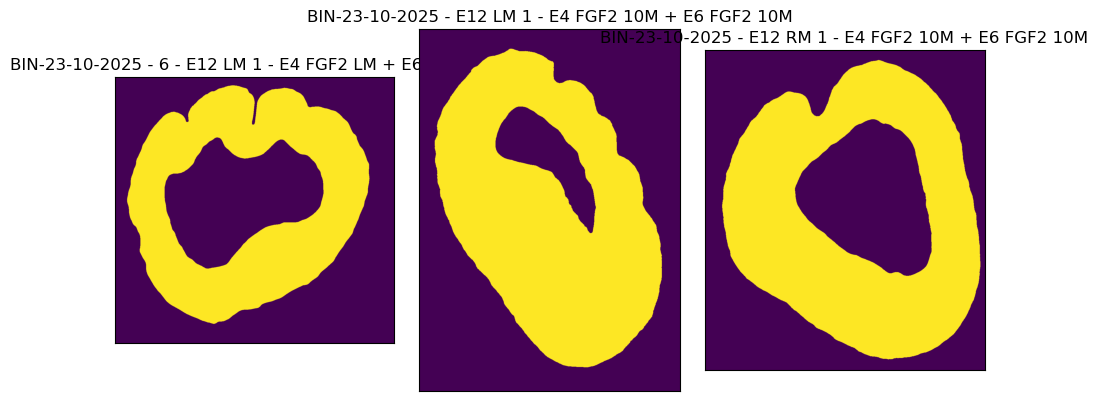

In [5]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

for i, name in enumerate(names):

    donut, res = get_picture2D(f'{folder}/{name}.tif')

    axs[i].set_title(name)
    axs[i].imshow(donut)



for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()


In [6]:
df = pd.DataFrame()

complete_dfs = []
pics = []


for name in names:
    print(name)

    donut, res = get_picture2D(f'{folder}/{name}.tif')
    ref_points, _ = get_picture2D(f'{folder}/{name}_points.tif')

    current_df, complete_df, donut = thick_analysis(donut, ref_points, res)
    current_df['brain'] = name

    
    if len(df) == 0:
        df = current_df
    else:
        df = pd.concat([df, current_df], ignore_index=True)
    
    complete_dfs.append(complete_df)
    pics.append(donut)

    print()


BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E6 FGF2 LM
smoothing factor = 14.36


100%|██████████| 2871/2871 [01:01<00:00, 46.57it/s]
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7492\1908248286.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['brain'] = name



BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 FGF2 10M
smoothing factor = 13.63


100%|██████████| 2453/2453 [00:41<00:00, 58.96it/s]
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7492\1908248286.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['brain'] = name



BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 FGF2 10M
smoothing factor = 14.39


100%|██████████| 2844/2844 [00:50<00:00, 55.95it/s]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_7492\1908248286.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_df['brain'] = name


In [7]:
letters = list(string.ascii_uppercase)

brain_name_map = {b_full_name: letters[i] for i, b_full_name in enumerate(df['brain'].unique())}

df['nickname'] = df['brain'].map(brain_name_map)

brain_name_map

{'BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E6 FGF2 LM': 'A',
 'BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 FGF2 10M': 'B',
 'BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 FGF2 10M': 'C'}

In [8]:
df.head()

,norm,dist,quadrant,brain,nickname
0,0.000000,269.772893,1,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
1,0.000275,269.974923,1,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
2,0.000549,270.176954,1,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
3,0.000824,270.378984,1,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
4,0.001099,270.581015,1,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A


In [9]:
quad_loc = df['quadrant'].diff()
quad_loc[0] = 1
quad_loc

quad_ind = quad_loc[quad_loc != 0].index
print(quad_ind)

quad_df = df.loc[quad_ind]

quad_df

Index([0, 774, 1817, 2688, 3642, 4076, 4681, 6110, 6508, 7135, 7905, 9121], dtype='int64')


,norm,dist,quadrant,brain,nickname
0,0.000000,269.772893,1,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
774,0.212579,300.403826,2,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
1817,0.499039,217.074011,3,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
2688,0.738259,311.826320,4,BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
3642,0.000000,194.822857,1,BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
4076,0.151483,275.452949,2,BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
4681,0.362653,285.989836,3,BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
6110,0.861431,295.451124,4,BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
6508,0.000000,229.917850,1,BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 F...,C
7135,0.184195,228.886306,2,BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 F...,C


(0.0, 972.2280034295768)

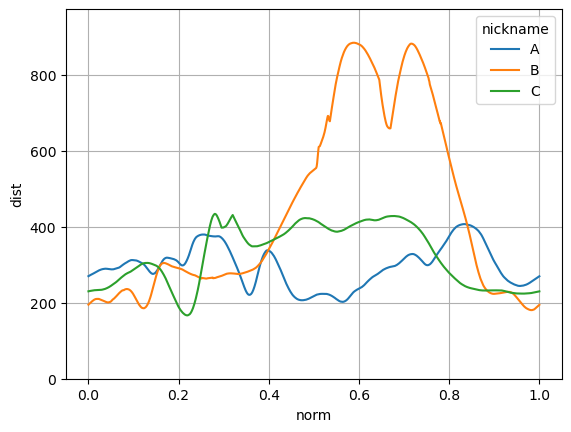

In [10]:
sns.lineplot(data=df, x='norm', y='dist', hue='nickname')

palette = sns.color_palette('deep', df['nickname'].nunique())
color_map = dict(zip(df['nickname'].unique(), palette))
# plt.vlines(quad_df['norm'], ymin=0, ymax=df['dist'].max()*1.1, colors=quad_df['nickname'].map(color_map))

plt.grid()
plt.ylim(0, df['dist'].max()*1.1)

In [22]:
colors = ['#ba274a', '#FE7F2D', '#FCCA46', '#519E8A']
quad_colors = ListedColormap(colors, name='quad_colors')

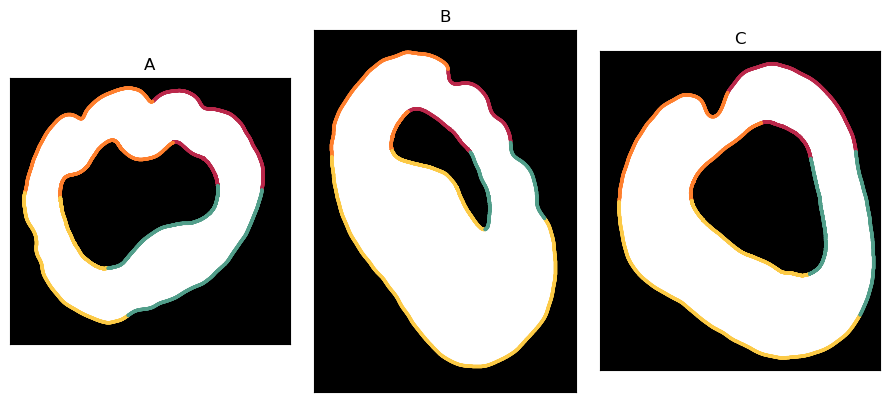

In [23]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

s=2
cmap=quad_colors

for i, name in enumerate(names):

    axs[i].set_title(letters[i])
    axs[i].imshow(pics[i], cmap='gray')

    current_df = complete_dfs[i]

    out_df = current_df.dropna(subset=['p_out'])
    p_out = out_df['p_out']
    xs = [p[0] for p in p_out]
    ys = [p[1] for p in p_out]
    axs[i].scatter(ys, xs, c = out_df['quadrant'], s = s, cmap=cmap)


    in_df = current_df.dropna(subset=['p_in'])
    p_in = in_df['p_in']
    xs = [p[0] for p in p_in]
    ys = [p[1] for p in p_in]
    axs[i].scatter(ys, xs, c = in_df['quadrant'], s = s, cmap=cmap)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(f'{folder}/quadrants.png')
plt.tight_layout()
plt.show()

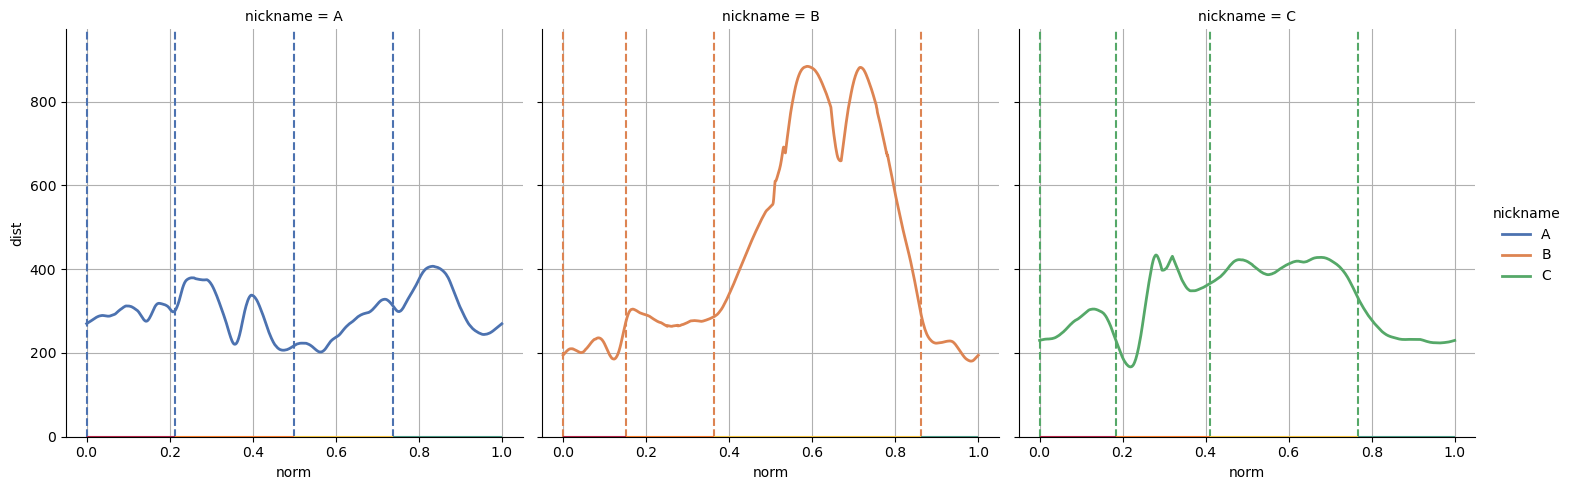

In [ ]:
g = sns.relplot(
    data=df,
    x='norm', y='dist',
    hue='nickname',
    col='nickname',
    kind='line',
    palette='deep',
    linewidth=2,
    col_wrap=3  # adjust layout
)

for nick, ax in g.axes_dict.items():
    subset = quad_df[quad_df['nickname'] == nick]
    ax.vlines(
        subset['norm'],
        ymin=0,
        ymax=df['dist'].max()*1.1,
        colors=color_map[nick],
        linestyles='--'
    )

    quad_points = list(subset['norm']) + [1]
    for i in range(4):
        ax.hlines(
            10,
            xmin=quad_points[i],
            xmax=quad_points[i+1],
            colors = colors[i]
        )

    ax.grid()
    ax.set_ylim(0, df['dist'].max()*1.1)